In [1]:
# Developer Lab Notebook
# Experiment: Measure Inference Cost and GPU Usage

In [2]:
%matplotlib inline
import sys, os
sys.path.append(os.path.abspath(".."))

In [3]:
"""
7. The discussion section briefly mentions the model’s computational cost but lacks concrete details. 
Given that transformer-based models are known for their high resource requirements, it is important to 
report metrics such as average inference time per genome, GPU memory usage, and scalability. In addition, 
potential solutions like model compression or inference-time optimization could be discussed to make the 
tool more accessible for users with limited computational resources. (ok 5)
"""

'\n7. The discussion section briefly mentions the model’s computational cost but lacks concrete details. \nGiven that transformer-based models are known for their high resource requirements, it is important to \nreport metrics such as average inference time per genome, GPU memory usage, and scalability. In addition, \npotential solutions like model compression or inference-time optimization could be discussed to make the \ntool more accessible for users with limited computational resources. (ok 5)\n'

TIS Prediction: 100%|██████████| 2/2 [00:14<00:00,  7.12s/it]


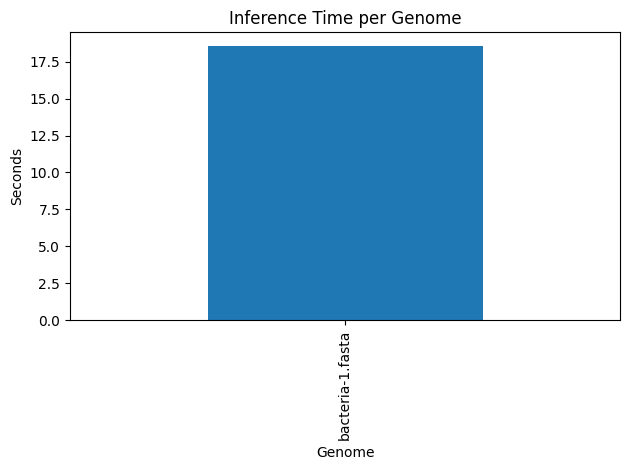

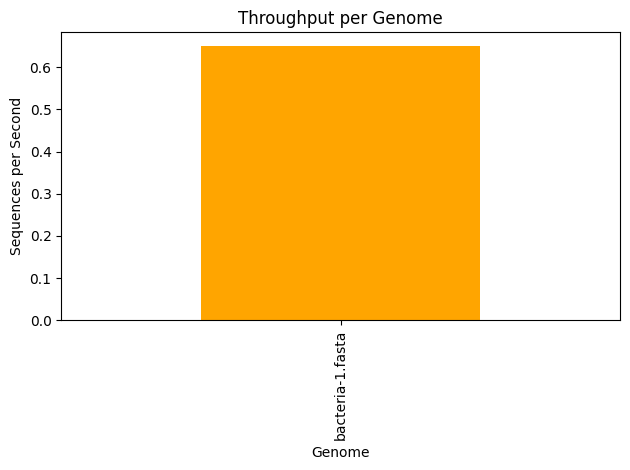

✅ Saved results to 'inference_benchmark_results.csv'


In [5]:
import torch
import pandas as pd
import numpy as np
import time
import gc
import os
from pathlib import Path
from api.core import AnnotatorPipeline
import matplotlib.pyplot as plt
from datetime import datetime
import logging

annotator = AnnotatorPipeline()
genome_files = [
    './data2-genome/bacteria-1.fasta',
    './data2-genome/bacteria-2.fasta',
    './data2-genome/bacteria-3.fasta'
]
results = []

# Get GPU info
def get_gpu_info():
    if torch.cuda.is_available():
        props = torch.cuda.get_device_properties(annotator.device)
        return props.name, round(props.total_memory / (1024**3), 2)
    return "CPU", 0

gpu_name, gpu_total_mem = get_gpu_info()

# Benchmark each genome
for genome_file in genome_files:
    torch.cuda.empty_cache()
    gc.collect()

    output_format = "CSV"
    uuid = Path(genome_file).stem + "-benchmark"
    tasks = {uuid: {"progress": 0, "status": "", "result": "", "exec_state": {}}}

    start_gpu_mem = torch.cuda.memory_allocated() / (1024**2) if torch.cuda.is_available() else 0
    start_time = time.time()

    result_path = annotator.pipeline(Path(genome_file), output_format, tasks, uuid, logging=logging)

    end_time = time.time()
    end_gpu_mem = torch.cuda.memory_allocated() / (1024**2) if torch.cuda.is_available() else 0

    total_time = round(end_time - start_time, 2)
    peak_mem = round(end_gpu_mem - start_gpu_mem, 2)
    file_size_kb = os.path.getsize(genome_file) / 1024

    try:
        df = pd.read_csv(result_path)
        n_preds = len(df)
        throughput = round(n_preds / total_time, 2) if total_time > 0 else 0
    except:
        n_preds = 0
        throughput = 0

    results.append({
        "Genome": Path(genome_file).name,
        "GPU Name": gpu_name,
        "GPU Total Memory (GB)": gpu_total_mem,
        "Batch Size": annotator.batch_size,
        "File Size (KB)": round(file_size_kb, 2),
        "Inference Time (s)": total_time,
        "Peak GPU Memory (MB)": peak_mem,
        "Number of Predictions": n_preds,
        "Throughput (seqs/sec)": throughput,
        "Output Path": str(result_path)
    })

# Save and visualize results
df_results = pd.DataFrame(results)
df_results.to_csv(f"inference_performance_benchmarck-{gpu_name}.csv", index=False)

# Plot
df_results.plot.bar(x="Genome", y="Inference Time (s)", title="Inference Time per Genome", legend=False)
plt.ylabel("Seconds")
plt.tight_layout()
plt.show()

df_results.plot.bar(x="Genome", y="Throughput (seqs/sec)", title="Throughput per Genome", color="orange", legend=False)
plt.ylabel("Sequences per Second")
plt.tight_layout()
plt.show()

print("✅ Saved results to 'inference_benchmark_results.csv'")